In [2]:
%matplotlib inline

from __future__ import division, print_function

import warnings
import pickle
import os

import seaborn as sns
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from scipy.sparse import csr_matrix, vstack
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from collections import Counter
from tqdm import tqdm
from glob import glob

from matplotlib import pyplot as plt

pd.set_option('display.max.columns', 25)
warnings.filterwarnings('ignore')
PATH_TO_DATA = '../data/capstone_user_identification/'

### 1 Цели и задачи проекта, описание исходных и обработанных данных и признаков

Основной задачей этого проекта было научиться по предоставленным данный по пользовательским сессиям определять конкретных пользователей пользователей. Что само по себе является достаточно интересной и не всегда технически простой задачей.

### 2 Описание исходных и обработанных данных и признаков. Первичный анализ

Исходные данные в сыром виде на первый взгляд представляли собой достаточно простой набор, а именно:  
* Timestamp когда пользователь пришел на сайт
* Доменное имя сайта

Но при более детальном рассмотрении эти признаки дают возможность создания достаточно большого количества признаков для обучения.
Например это может быть:
* Сессия из нескольких последовательно посещенных сайтов (как с ограничениями по времени или длине окна так и без)
* Продолжительность сессии
* Среднее время прибывания на сайте
* Время суток когда пользователь предпочитает сидеть в интернете
* Или время года
* Так же полезными могут оказаться признаки посещения популярных сайтов, почтовых или развлекательных ресурсов

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    with (open(site_freq_path, 'rb')) as file:
        site_freq = pickle.load(file)
        
    next_user_id = 1
    rows = []
    
    for file in tqdm(glob(os.path.join(path_to_csv_files, '*.csv'))):
        
        data = pd.read_csv(file, parse_dates=['timestamp']) 
        sites = data.site.values
        session_count = int(len(sites) / window_size) + (1 if (len(sites) % window_size) != 0 else 0)

        for idx in range(0, session_count):
            
            bound = min(idx *  window_size + session_length, len(sites))
            
            current_session = [site_freq[s][0] for s in sites[idx * window_size : bound]]
            sessions_timestamps = [t for t in data.timestamp[idx * window_size : bound]]
            
            seconds = (sessions_timestamps[len(sessions_timestamps) - 1] - sessions_timestamps[0]).seconds
            hour = sessions_timestamps[0].hour
            day = sessions_timestamps[0].dayofweek
            unique = len(set(current_session))
            
            if len(current_session) < 10:
                current_session = current_session + [0] * (10 - len(current_session))
            
            row = current_session + [seconds, unique, hour, day, next_user_id]
            rows.append(row)
            
        next_user_id = next_user_id + 1
    
    return pd.DataFrame(rows, columns=feature_names)

In [6]:
%%time
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'user_id']
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.56it/s]


Wall time: 7.16 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,1,2,3,4,3,3,4,3,5,3,33,5,8,4,1
1,6,7,8,9,3,10,11,12,13,14,284,10,8,4,1
2,14,4,14,14,15,16,6,17,18,14,258,7,8,4,1
3,19,20,19,14,14,14,14,21,22,23,30,6,8,4,1
4,24,14,15,25,26,27,28,29,30,29,6,9,8,4,1


In [8]:
new_features_10users = train_data_10users[train_data_10users.columns[10:14]]

In [9]:
id_name_dict = {7: 'Mary-Kate', 3: 'Ashley', 8: 'Lindsey', 6: 'Naomi', 9: 'Avril',
               2: 'Bob', 4: 'Bill', 1: 'John', 5: 'Dick', 10: 'Ed'}
train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [10]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

### 3 Описание предобработки данных

Во время предобработки данных бало произведено формирование нескольких файлов с сессиями различной длины. А так же были извлечены дополнительные признаки такие как:
* Кол-во уникальных сайтов в сессии
* Временные показатели, такие как час начала и продолжительность сессий
* День недели
* Признаки посещения популярных ресурсов, а так же популярных доменов 1 и 2 уровней

### 4 Визуальный анализ признаков

В процессе визуального внализа признаков было выявлено что в сессии из 10 сайтов с окном в 10 посещенные сайты достаточно сильно коррелируют с целевой переменной, но так же было выявлено два признака час старта сессии и кол-во популярных сайтов так же вносят большой вклад в модель.

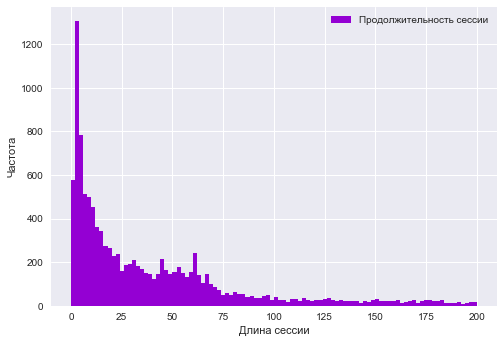

In [11]:
hist = train_data_10users['session_timespan'].hist(range=(0, 200), bins=100, color='darkviolet', label = 'Продолжительность сессии')
hist.set(xlabel="Длина сессии", ylabel="Частота")
hist.legend()

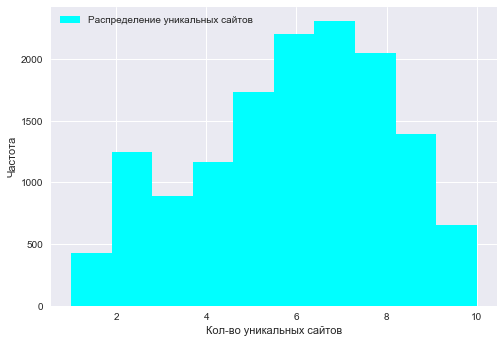

In [12]:
hist = train_data_10users['#unique_sites'].hist(bins=10, color='aqua', label = 'Распределение уникальных сайтов')
hist.set(xlabel="Кол-во уникальных сайтов", ylabel="Частота")
hist.legend()

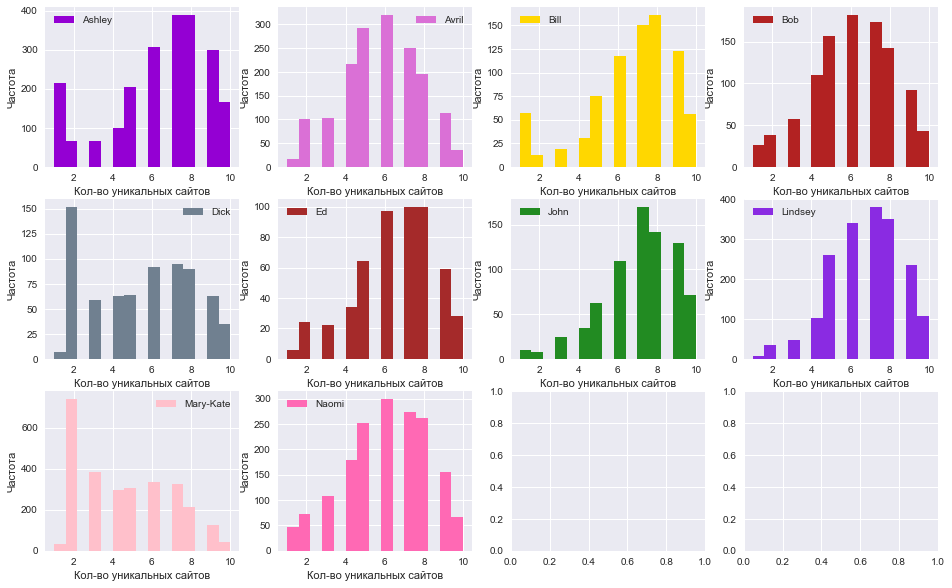

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

axes_flatten = axes.flatten()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
#      ''' ВАШ КОД ЗДЕСЬ '''
    axes_flatten[idx].hist(sub_df['#unique_sites'], bins=15, stacked=True, color = color_dic[user], label = user)
    axes_flatten[idx].set(xlabel="Кол-во уникальных сайтов", ylabel="Частота")
    axes_flatten[idx].legend()

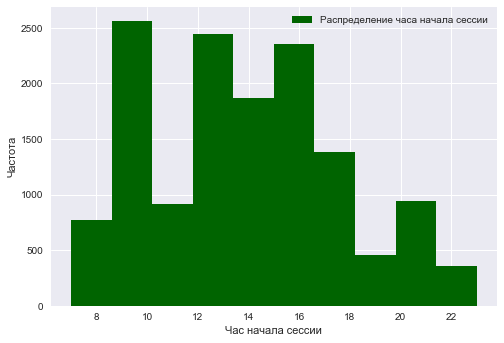

In [14]:
hist = train_data_10users['start_hour'].hist(bins=10, color='darkgreen', label = 'Распределение часа начала сессии')
hist.set(xlabel="Час начала сессии", ylabel="Частота")
hist.legend()

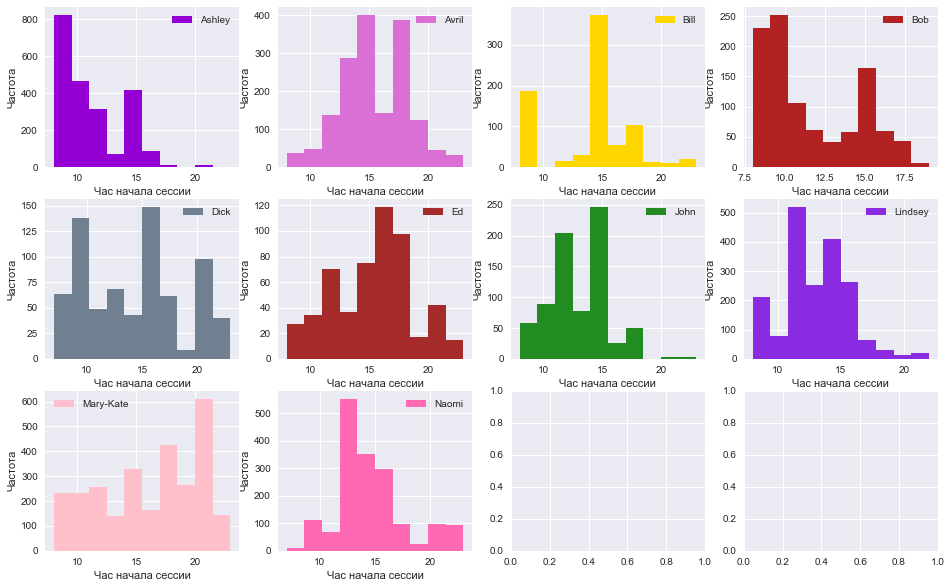

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

axes_flatten = axes.flatten()

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['start_hour'], bins=10, stacked=True, color = color_dic[user], label = user)
    axes_flatten[idx].set(xlabel="Час начала сессии", ylabel="Частота")
    axes_flatten[idx].legend()

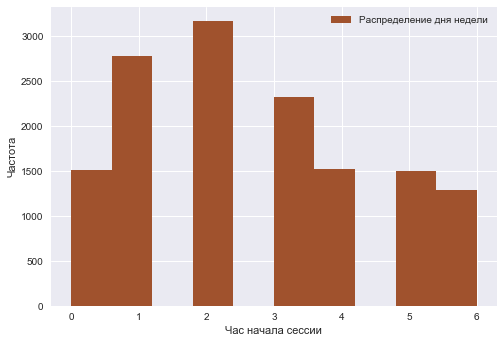

In [16]:
hist = train_data_10users['day_of_week'].hist(bins=10, color='sienna', label = 'Распределение дня недели')
hist.set(xlabel="Час начала сессии", ylabel="Частота")
hist.legend()

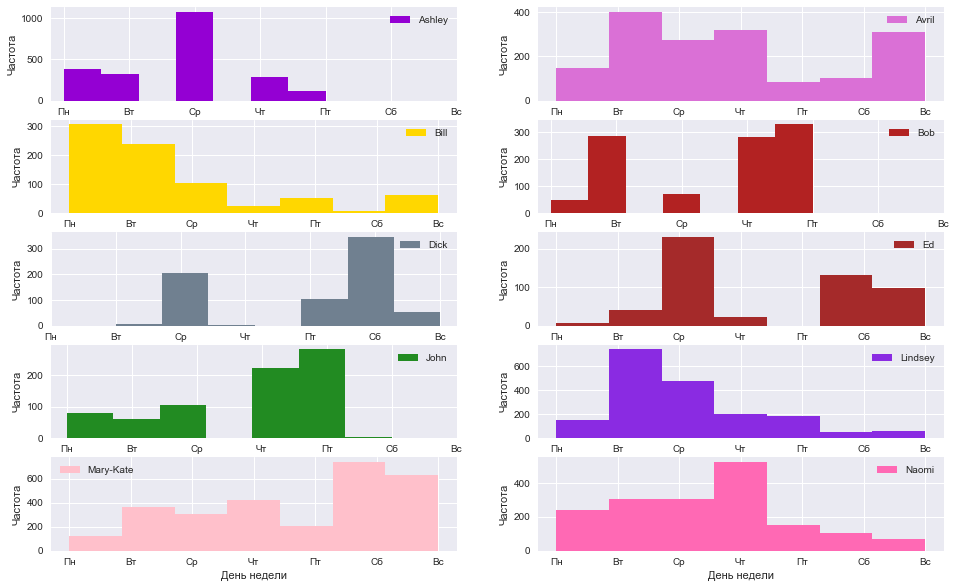

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 10))

axes_flatten = axes.flatten()
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['day_of_week'], bins=7, align='mid', color = color_dic[user], label = user)
    axes_flatten[idx].set(xlabel="День недели", ylabel="Частота", xticklabels=days, xticks=np.arange(len(days)))
    axes_flatten[idx].legend()

По построенным графикам можно сделать следующие выводы:
 * Все пользователи посещают примерно 6-8 различных сайтов за сессию, хотя есть и исключение, например Mary-Kate
 * Пользователи значительно различаются по времени старта сессий, кто-то сидит в интернете больше по утрам, кто-то в течении всего дня (предположу что это так же может зависеть от рода деятельности пользователя)
 * По гистограммам распределения дня начала сессии можно утверждать что пользователи на удивление сидят в интернете больше в рабочие дни, чем в выходные.

In [19]:
site_freq_path = os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl')
with (open(site_freq_path, 'rb')) as file:
    site_freq = pickle.load(file)

In [20]:
top10_sites = sorted(site_freq.keys(), key=lambda x: site_freq[x][1], reverse=True)[:10]
top10_freqs = [site_freq[s][1] for s in top10_sites]

print(top10_sites)
print()
print(top10_freqs)

['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

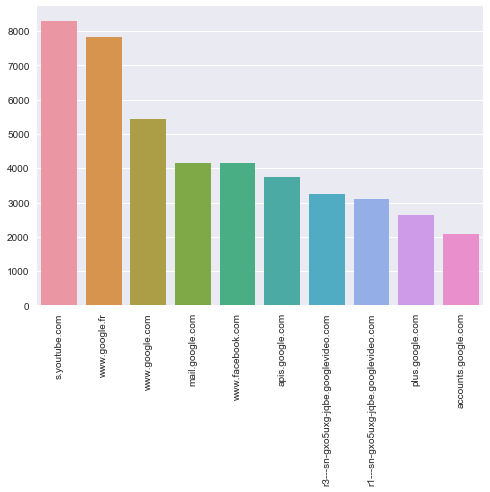

In [21]:
ax = sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90)

In [22]:
def get_top(site_freq, token, top):
    count = Counter([x.split('.')[token:][0] for x in site_freq])
    return pd.Series(count).sort_values(ascending=False).index[:top]

In [23]:
def extract_part_of_day_and_season(date):
    part_of_day = 0
    season = 0
    
    if date.hour > 1 and date.hour < 8:
        part_of_day = 1
    elif date.hour > 8 and date.hour < 18:
        part_of_day = 2
    else:
        part_of_day = 3

    season = 1 if date.month == 12 else date.month // 3 + 1
        
    return part_of_day, season

In [24]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    with (open(site_freq_path, 'rb')) as file:
        site_freq = pickle.load(file)
        
    first_level = get_top(site_freq, -1, 1)    
    second_level = get_top(site_freq, -2, 10)    
    top50_ids = [site_freq[s][0] for s in sorted(site_freq.keys(), key=lambda x: site_freq[x][1], reverse=True)[:50]]
        
    next_user_id = 1
    rows = []
    
    feature_names = ['average_time', 'popular_sites', 'fl', 'sl', 'part_of_day', 'season', 'user_id']
    
    for file in tqdm(glob(os.path.join(path_to_csv_files, '*.csv'))):

        data = pd.read_csv(file, parse_dates=['timestamp']) 
        sites = data.site.values
        
        session_count = int(len(sites) / window_size) + (1 if (len(sites) % window_size) != 0 else 0)
        
        for idx in range(0, session_count):
            
            bound = min(idx *  window_size + session_length, len(sites))
            
            current_session = sites[idx * window_size : bound]
            sessions_timestamps = [t for t in data.timestamp[idx * window_size : bound]]
            
            counts_pop_sites = sum([site_freq[s][0] in top50_ids for s in current_session])
            avg = np.array([(sessions_timestamps[idx + 1] - sessions_timestamps[idx]).seconds \
                            for idx, _ in enumerate(sessions_timestamps) if idx + 1 != len(sessions_timestamps)]).mean()
            popular_first = sum([s.split('.')[-1:][0] in first_level for s in current_session])
            popular_second = sum([s.split('.')[-2:][0] in second_level for s in current_session])
            
            part_of_day, season = extract_part_of_day_and_season(sessions_timestamps[0])
            
            row = [avg, counts_pop_sites, popular_first, popular_second, part_of_day, season, next_user_id]
            rows.append(row)
            
        next_user_id = next_user_id + 1
    
    return pd.DataFrame(rows, columns=feature_names)

In [25]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  session_length=10) 

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


#### Среднее время пребывания на сайте

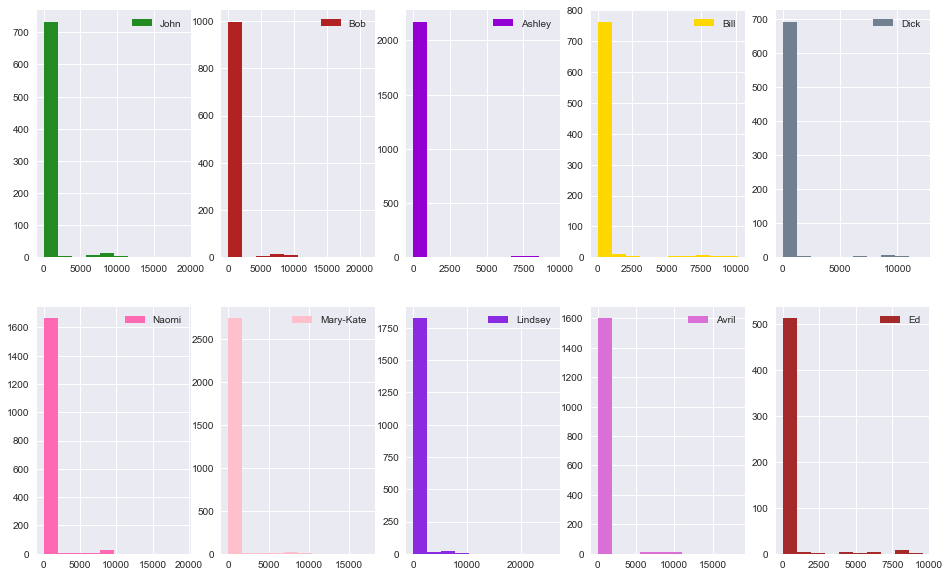

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 10))

axes_flatten = axes.flatten()

for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    axes_flatten[idx].hist(sub_df['average_time'].dropna(), bins=10, color = color_dic[id_name_dict[user]], label = id_name_dict[user])
    axes_flatten[idx].legend()

In [27]:
def hist(col, nrows=5, ncols=2, bins=10):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10))

    axes_flatten = axes.flatten()

    for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
        axes_flatten[idx].hist(sub_df[col], bins=bins, color = color_dic[id_name_dict[user]], label = id_name_dict[user])
        axes_flatten[idx].legend()

#### Кол-во сайтов из топ 30 в сессии

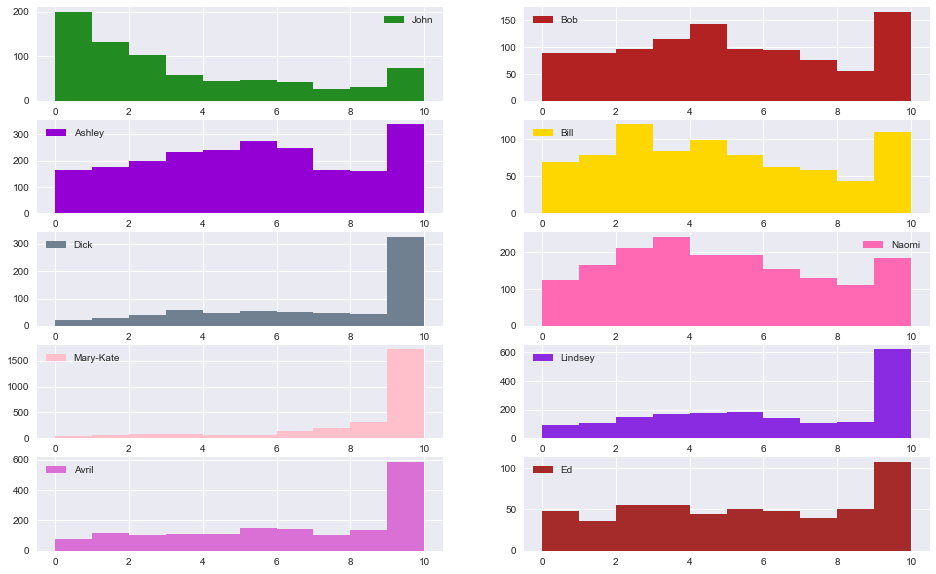

In [28]:
hist('popular_sites')

#### Кол-во сайтов из зоны .com

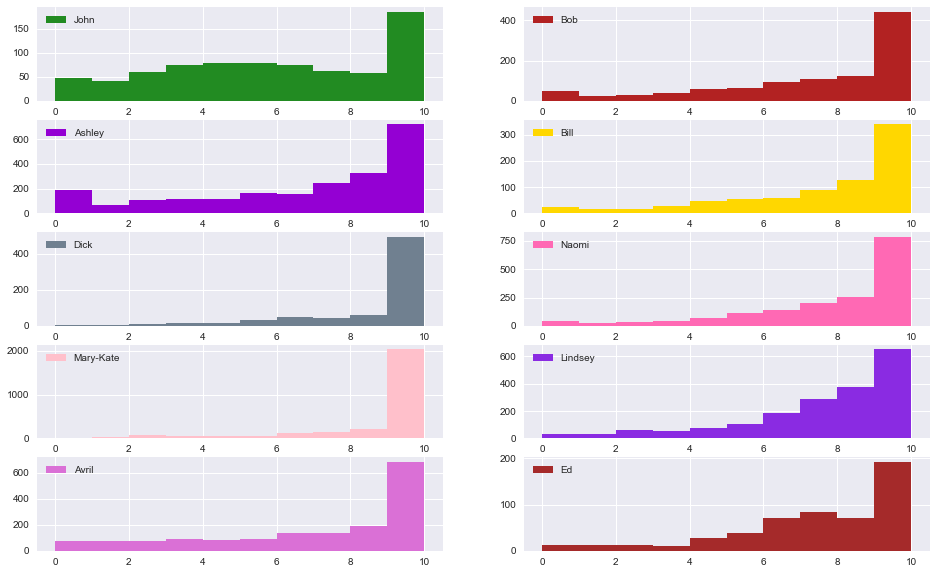

In [29]:
hist('fl')

#### Кол-во сайтов из топ 10 доменов второго уровня

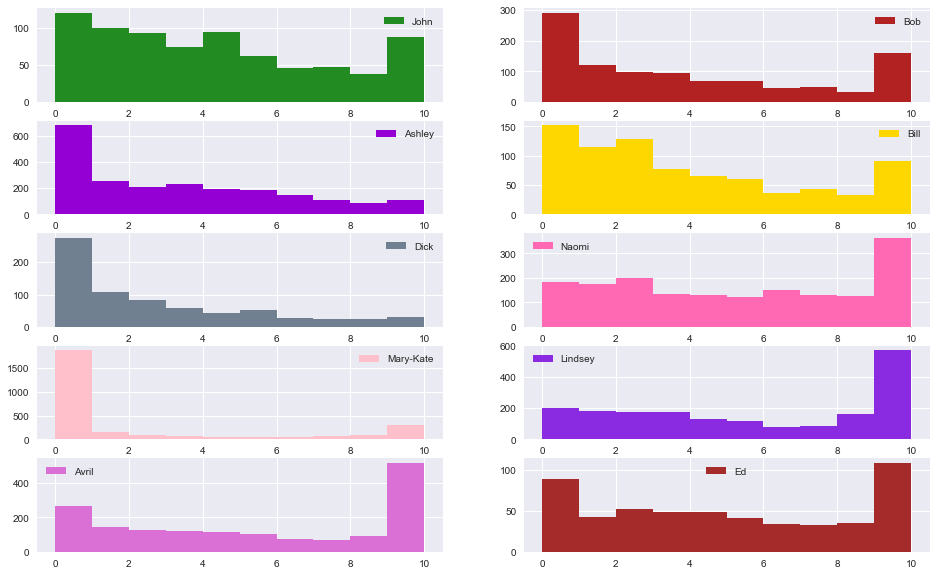

In [30]:
hist('sl')

#### Время суток (утро, день вечер)

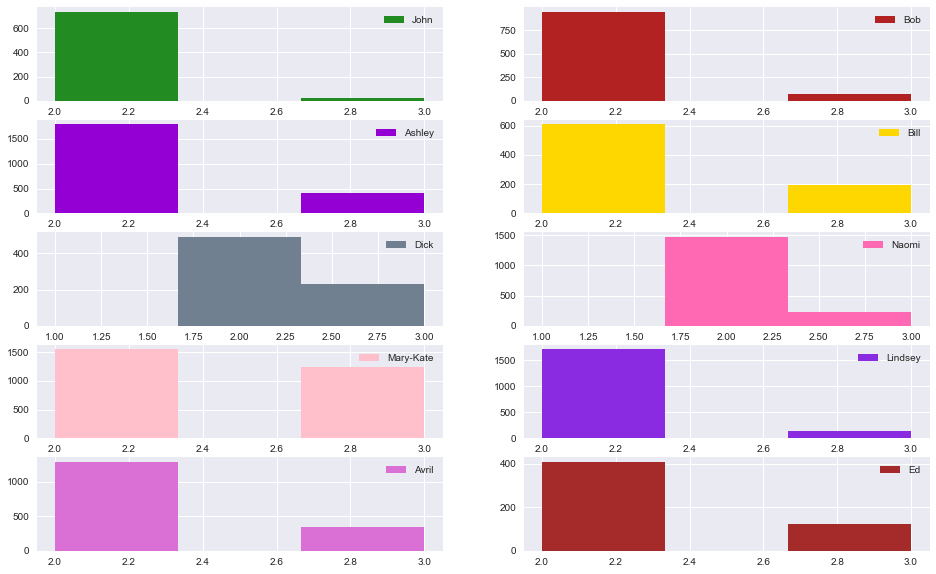

In [31]:
hist('part_of_day', bins=3)

####  Время года

Информация за осень в выборке отсутствует

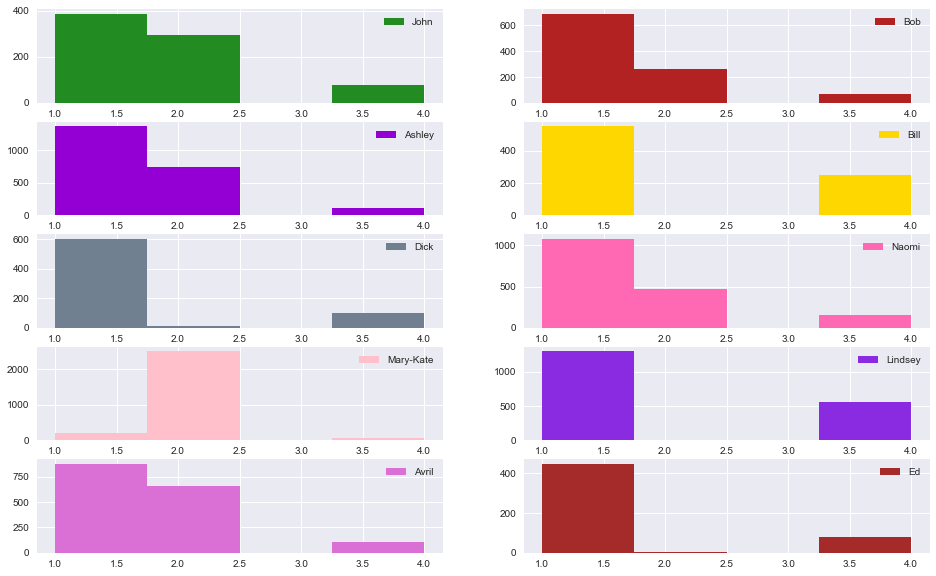

In [32]:
hist('season', bins=4)

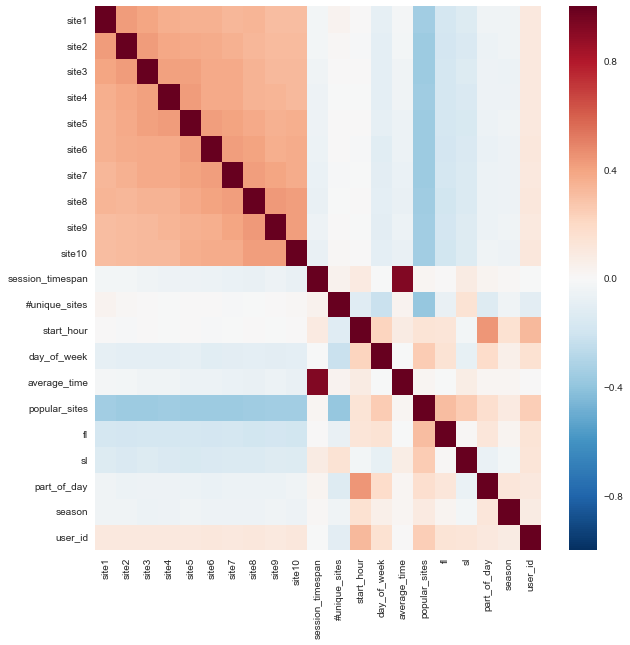

In [33]:
temp = pd.concat([train_data_10users[train_data_10users.columns[:-1]], new_features_10users], axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(temp.corr())

Были проанализированы новые признаки:
 * Среднее время на сайте
 * Кол-во сайтов из топ 50 в одной сессии
 * Посещение домена com 
 * Посещение top 10 доменов второго уровня
 * Время суток (утро, рабочее время, вечер)
 * Время года
 
Из гистограмм видно что маловероятно что первый признак может принести пользу в обучении модели.
А вот с остальными можно попробовать поработать, хотя по некоторым из них так же имеются большие сомнения.
Так же следует отметить что как и ожидалось среднее время проведенное на сайте илнейно зависимо от полного времени сессии

### 5 Кросс-валидация

На четвертой недели проекта было проведено первое обучение моделей и сравнение полученных результатов.
В просессе обучения были применены модели:
* LogisticRegression
* LinearSVC
* SGDClassifier

Лучшее качество было показано моделью LogisticRegression. Однако из минусов стоит отметить что эта модель достаточно долго обучается, особенно в сравнении с SGDClassifier и не всегда сильно отличается по качеству.

Так же в просессе прохождения курса была изучен новый tool Vowpal Wabbit, который достаточно быстро обучается и дает очень высокую точность предсказаний. 

In [34]:
PATH_TO_DATA = '../data/capstone_user_identification/kaggle/' 

In [35]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [36]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [37]:
len(np.unique(train_df.target))

2

In [38]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [39]:
train_test_df = pd.concat([train_df, test_df])

In [40]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [41]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


In [42]:
def get_dense_matrix(matrix):
    site_ids = set(el for row in matrix.values for el in row)
    X = matrix.values
    
    i = 0
    data = list()
    col = list()
    rows = list()
    for row in tqdm(X):
        unique, counts = np.unique(row, return_counts=True)
        dic = dict(zip(unique, counts))
        for k in dic:
            if (k == 0):
                continue
            
            data.append(dic[k])
            rows.append(i)
            col.append(k-1)
            
        i += 1
    X_sparse = csr_matrix((data, (rows, col)), shape=(X.shape[0], len(site_ids)))
    return X_sparse

In [44]:
train_test_sparse = get_dense_matrix(train_test_df_sites)

100%|█████████████████████████████████████████████████████████| 336358/336358 [00:21<00:00, 15894.17it/s]


In [45]:
X_train_sparse = train_test_sparse[:len(train_df)]
X_test_sparse = train_test_sparse[len(train_df):]
y = train_df.target

In [46]:
print('Total size {}'.format(train_test_sparse.shape))
print('Train size {}'.format(X_train_sparse.shape))
print('Test size {}'.format(X_test_sparse.shape))
print('Y size {}'.format(len(y)))

Total size (336358, 48372)
Train size (253561, 48372)
Test size (82797, 48372)
Y size 253561


In [47]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

In [48]:
%%time
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

Wall time: 504 ms


In [49]:
valid_pred_proba = sgd_logit.predict_proba(X_valid) 
roc_auc_score(y_valid, valid_pred_proba[:, 1:])

0.93384728679061502

In [50]:
%%time

pipe = Pipeline([
    ("classifier", SGDClassifier())
])

param_grid = [
    {    
    'classifier__alpha': [0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001], 
    'classifier__loss': ["log"],
    'classifier__tol': [1e-50]
    }
]

grid = GridSearchCV(pipe, cv=3, n_jobs=-1, param_grid=param_grid, scoring='roc_auc')
grid.fit(X_train, y_train)

print(grid.best_score_)
print()
for k in grid.best_params_:
    print(k, " : ", grid.best_params_[k])

valid_score = grid.predict_proba(X_valid)
print(roc_auc_score(y_valid, valid_score[:, 1:]))

0.933766512899

classifier__alpha  :  0.0001
classifier__loss  :  log
classifier__tol  :  1e-50
0.936206756005
Wall time: 14.7 s


####  Оценка модели

На мой взгляд наиболее спроведливой оценкой являются результаты соревнований:

* <a href="https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2">Intruder detection through webpage session tracking</a>  

Где было необходимо построить модель которая из всех представленных пользователей сможет находить одного конкретного. Задача усложняется тем что на лицо значительный перевес в сторону одного из классов, так что оценка точности в такой ситуации является бесполезной. В качестве оценночной метрики на соревновании применялась roc_auc_score. Результат которого удалось добиться, на момент написания отчета составляет 0.90812.

### 7 Выводы

Идентификация пользователя по каким-либо признакам является не совсем привиальной задачей при решении которой необходимо учитывать многие факторы и анализоровать большое количество признаков которые помогут отделить одних пользователей от других.
В случае с идентификацией пользователей по их сессиям это например может быть:
* Кто-то из пользователей предвочитает сидеть в интернете вечером, кто-то только в рабочее время.
* У кого-то сессии могут повторяться и состоять из одних и тех же развлекательных или каких-либо еще ресурсов определенной тематики. А кто-то в тоже время может постоянно серфить интернет на предмет чего-то нового.

Однако задачи такого тима могут быть полездны в разных областях:
* Как было приведено в начальном примере можно улавливать случаи взломов почновых ящиков или каких-либо еще аккаунтов
* Улавливать случаи мошеннических действий с кредитными картами или банковскими аккаунтами.
* И многое другое